# Prize-Collecting Steiner Trees (PCST)

The PCST is a generalization of the [Steiner Tree problem](steiner-trees.ipynb). In PCST, each vertex has a prize associated with it, and each edge has a cost. The objective is to find a tree that maximizes the difference between the total prize collected from the vertices in the tree and the total cost of the edges used. Unlike the Steiner Tree problem, where you must connect all terminal vertices, in PCST, you can choose to exclude some vertices (even terminal vertices) if the cost of connecting them is too high relative to their prize. The optimization problem is defined as:


$$ \text{argmin}_{x_v, y_e} L(x_v, y_e) = \sum_{e \in E} c_e y_e - \sum_{v \in V} p_v x_v $$

Where $c_e$ is the cost of edge $e$, $p_v$ is the prize of vertex $v$, $x_v$ is a binary variable indicating whether vertex $v$ is included in the tree, and $y_e$ is a binary variable indicating whether edge $e$ is included in the tree.


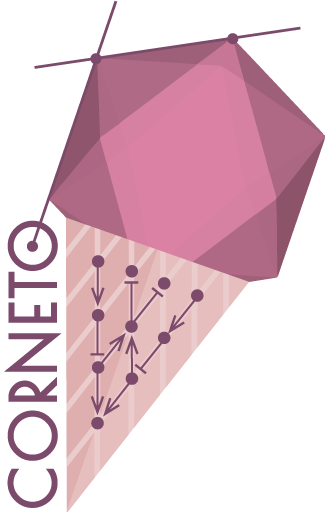

In [1]:
import matplotlib.pyplot as plt
import corneto as cn
import networkx as nx
import numpy as np
import random

# https://github.com/fraenkel-lab/pcst_fast
import pcst_fast

random.seed(0)

cn.info()

In [2]:
def generate_random_graph(num_nodes=100, probability=0.1, num_terminals=10, num_prized=10, prize_range=(1, 50)):
    """
    Generates a random weighted graph using the Erdős-Rényi model,
    assigns random weights to edges, random terminal nodes, and random prizes to a subset of nodes.

    Returns:
        G (networkx.Graph): The graph with 'value' on edges, 'terminal' and optionally 'prize' on nodes.
    """
    G = nx.erdos_renyi_graph(num_nodes, probability)

    # Assign edge weights
    for u, v in G.edges():
        G[u][v]['value'] = random.uniform(1, 10)

    # Random terminal nodes
    terminals = random.sample(list(G.nodes()), min(num_terminals, G.number_of_nodes()))
    for node in G.nodes():
        G.nodes[node]['terminal'] = node in terminals

    # Random prized nodes
    available_nodes = list(set(G.nodes()) - set(terminals))
    prized_nodes = random.sample(available_nodes, min(num_prized, len(available_nodes)))
    for node in prized_nodes:
        G.nodes[node]['prize'] = random.uniform(*prize_range)

    return G


def solve_pcst_with_pcst_fast(G, root=-1, num_clusters=1, pruning='strong', verbosity=0):
    """
    Solves the PCST problem on a NetworkX graph using pcst_fast from:
    https://github.com/fraenkel-lab/pcst_fast

    Args:
        G (networkx.Graph): Graph with 'value' on edges and 'prize' on nodes.
        root (int): Index of the root node (or -1 for unrooted).
        num_clusters (int): Desired number of clusters in the solution.
        pruning (str): Pruning method ('none', 'simple', 'gw', 'strong').
        verbosity (int): Verbosity level.

    Returns:
        selected_nodes (list): Node IDs included in the PCST solution.
        selected_edges (list): Edge tuples included in the solution.
    """
    node_list = list(G.nodes())
    node_index_map = {node: i for i, node in enumerate(node_list)}
    index_node_map = {i: node for node, i in node_index_map.items()}

    edge_list = []
    edge_costs = []
    for u, v, data in G.edges(data=True):
        edge_list.append([node_index_map[u], node_index_map[v]])
        edge_costs.append(data['value'])

    prizes = np.array([G.nodes[node].get('prize', 0) for node in node_list], dtype=np.float64)

    edges_array = np.array(edge_list, dtype=np.int64)
    costs_array = np.array(edge_costs, dtype=np.float64)

    vertices_out, edges_out = pcst_fast.pcst_fast(
        edges_array,
        prizes,
        costs_array,
        root,
        num_clusters,
        pruning,
        verbosity
    )

    selected_nodes = [index_node_map[i] for i in vertices_out]
    selected_edges = [tuple(node_list[idx] for idx in edge_list[i]) for i in edges_out]

    return selected_nodes, selected_edges


In [3]:
G = generate_random_graph(num_nodes=100, num_terminals=0, num_prized=6)

# Solve the problem heuristically, using pcst_fast
selected_nodes, selected_edges = solve_pcst_with_pcst_fast(G)
G.number_of_nodes(), G.number_of_edges()

(100, 511)

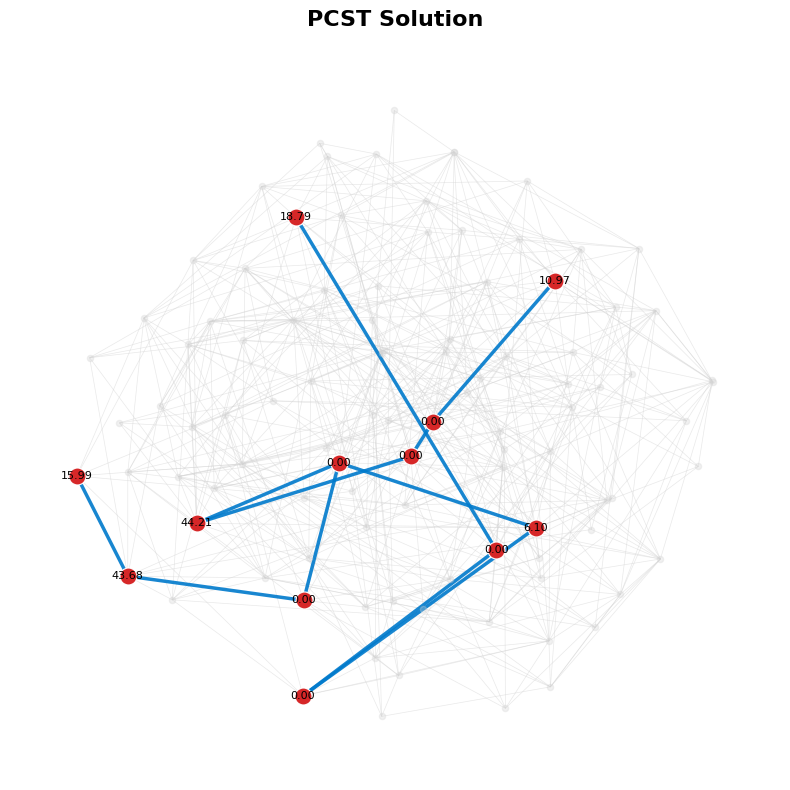

In [4]:
def compute_pcst_cost(G, selected_nodes, selected_edges):
    """
    Calculates the cost components and total PCST objective value.
    
    Returns:
        dict with 'edge_cost', 'prize_collected', and 'objective'
    """
    edge_cost = sum(G[u][v]['value'] for u, v in selected_edges)
    prize_collected = sum(G.nodes[n]['prize'] for n in selected_nodes if 'prize' in G.nodes[n])
    objective = edge_cost - prize_collected

    return {
        'edge_cost': edge_cost,
        'prize_collected': prize_collected,
        'objective': objective
    }

def visualize(G, selected_nodes, selected_edges):
    pos = nx.forceatlas2_layout(G, dissuade_hubs=False, seed=42)

    plt.figure(figsize=(8, 8))

    # Base layer: faint background graph
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5, edge_color='lightgray')
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightgray', alpha=0.3)

    # Selected edges (solution)
    nx.draw_networkx_edges(G, pos, edgelist=selected_edges, width=2.5, edge_color='#007acc', alpha=0.9)

    # Selected nodes (solution)
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_size=150, node_color='#d62728', edgecolors='white', linewidths=0.8)

    # Optional: add labels or prizes
    node_labels = {n: f"{(G.nodes[n].get('prize', 0)):.2f}" for n in selected_nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

    plt.title("PCST Solution", fontsize=16, fontweight='bold', pad=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize(G, selected_nodes, selected_edges)

In [5]:
pcst_fast_result = compute_pcst_cost(G, selected_nodes, selected_edges)
pcst_fast_result

{'edge_cost': 27.53087803410978,
 'prize_collected': 139.73652992602086,
 'objective': -112.20565189191109}

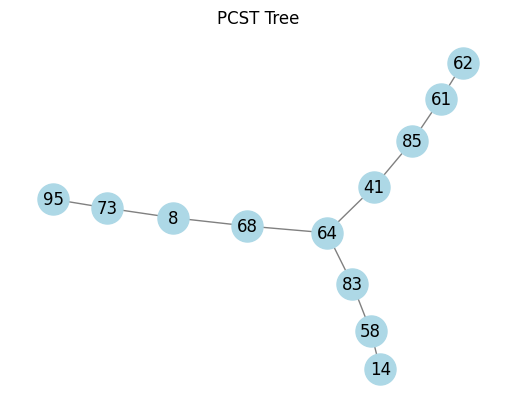

In [6]:
def plot_tree_from_edges(selected_edges):
    """
    Plots the tree defined by selected_edges using NetworkX.
    
    Args:
        selected_edges (list of tuple): List of (u, v) edges forming the tree.
    """
    if not selected_edges:
        print("No edges to plot.")
        return

    tree = nx.Graph()
    tree.add_edges_from(selected_edges)

    pos = nx.spring_layout(tree, seed=42)  # Nice layout for trees
    nx.draw_networkx(tree, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

    plt.title("PCST Tree")
    plt.axis('off')
    plt.show()


plot_tree_from_edges(selected_edges)

In [7]:
from corneto.contrib.networkx import networkx_to_corneto_graph, corneto_graph_to_networkx
Gc = networkx_to_corneto_graph(G)
Gc.shape

(100, 511)

In [8]:
from corneto._data import Data

def get_data(G):
    features = []
    
    for i, attr in enumerate(G.get_attr_edges()):
        features.append(dict(id=i, mapping="edge", value=attr.value))

    for v in G.V:
        attr = G.get_attr_vertex(v)
        if attr['terminal'] and not attr.get('prize', None):
            features.append(dict(id=v, mapping="vertex", role="terminal"))
        elif attr.get('prize', None):
            features.append(dict(id=v, mapping="vertex", role="prize", value=attr['prize']))
    D = Data.from_dict({"s1": {"features": features}})
    return D

D = get_data(Gc)
D

Data(n_samples=1, n_feats=[517])

In [9]:
from corneto.methods.future.pcst import PrizeCollectingSteinerTree as PCST

m = PCST(lambda_reg=0, strict_acyclic=True)
P = m.build(Gc, D)
P.expr

{'_flow': Variable((517,), _flow),
 '_flow_ipos': Variable((517,), _flow_ipos, boolean=True),
 '_flow_ineg': Variable((517,), _flow_ineg, boolean=True),
 '_dag_layer': Variable((100, 1), _dag_layer),
 'flow': Variable((517,), _flow),
 'with_flow': Expression(AFFINE, NONNEGATIVE, (517,)),
 'selected_prized_flow_edges_0': Expression(AFFINE, NONNEGATIVE, (6,))}

In [10]:
# We need to modify steiner since it is always enforcing the selection of all prizes, which
# are considered terminals
#P.solve(solver="gurobi", IntegralityFocus=1, TimeLimit=120, verbosity=0);
P.solve(solver="scipy");

In [11]:
print(P.objectives[0].value, P.objectives[1].value, P.objectives[0].value - P.objectives[1].value) 

24.493118581655732 139.73652992602086 -115.24341134436513


In [12]:
# Corneto recovers an alternative solution with less cost
pcst_fast_result['edge_cost'], P.objectives[0].value

(27.53087803410978, 24.493118581655732)

In [13]:
# Total prize is the same for both methods
pcst_fast_result['prize_collected'], P.objectives[1].value

(139.73652992602086, 139.73652992602086)

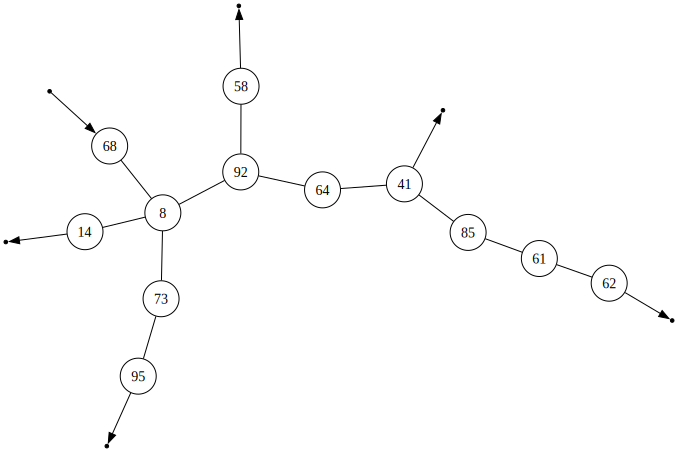

In [14]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value>0.5))
sol.plot(orphan_edges=True, layout="neato")

In [15]:
# Manually verify the cost of the solution
sum([attr.get("value", 0) for attr in sol.get_attr_edges()])

24.493118581655736

In [16]:
sol.shape

(12, 17)

In [17]:
edges = np.flatnonzero(P.expr.with_flow.value>0.5)
len(edges)

17

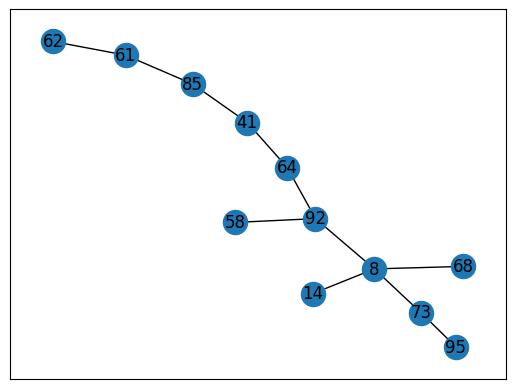

In [18]:
sol_nx = corneto_graph_to_networkx(sol, graph_class=nx.Graph)
nx.draw_networkx(sol_nx)

## Directed

In [19]:
G_dir = G.to_directed()
Gc = networkx_to_corneto_graph(G_dir)
D = get_data(Gc)

In [20]:
# Use automatic selection of the root vertex in the directed case
m = PCST(lambda_reg=0, strict_acyclic=True, root_selection_strategy="best")
P = m.build(Gc, D)
P.expr

{'_flow': Variable((1028,), _flow),
 '_flow_ineg': Variable((1028,), _flow_ineg, boolean=True),
 '_flow_ipos': Variable((1028,), _flow_ipos, boolean=True),
 '_dag_layer': Variable((100, 1), _dag_layer),
 '_flow_terminal_neg_0': Variable((6,), _flow_terminal_neg_0, boolean=True),
 '_flow_terminal_pos_0': Variable((6,), _flow_terminal_pos_0, boolean=True),
 'flow': Variable((1028,), _flow),
 'with_flow': Expression(AFFINE, NONNEGATIVE, (1028,)),
 'selected_prized_flow_edges_0': Expression(AFFINE, NONNEGATIVE, (6,))}

In [21]:
#P.solve(solver="gurobi", verbosity=1, TimeLimit=300, NoRelHeurTime=0);
P.solve(solver="scipy")

for o in P.objectives:
    print(o.value)

24.493118581655736
139.7365299260209
17.0


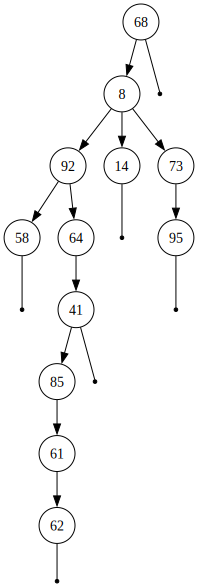

In [22]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(np.abs(P.expr.with_flow.value)>0.5))
sol.plot(orphan_edges=True)

In [23]:
sum([attr.get("value", 0) for attr in sol.get_attr_edges()])

24.493118581655736

In [24]:
D.samples['s1'].query.select(lambda f: f.mapping=="vertex").to_list()

[Feature(id=41, value=44.20976812709689, mapping=vertex, role=prize),
 Feature(id=95, value=18.78781422501993, mapping=vertex, role=prize),
 Feature(id=14, value=15.985955399733813, mapping=vertex, role=prize),
 Feature(id=68, value=6.10301691417026, mapping=vertex, role=prize),
 Feature(id=62, value=10.967555901582266, mapping=vertex, role=prize),
 Feature(id=58, value=43.6824193584177, mapping=vertex, role=prize)]

## Select a specific root vertex

We can also select a specific root from which we will build the PCST

In [25]:
m = PCST(lambda_reg=0, strict_acyclic=True, root_vertex=8)
P = m.build(Gc, D)
P.solve(solver="scipy");

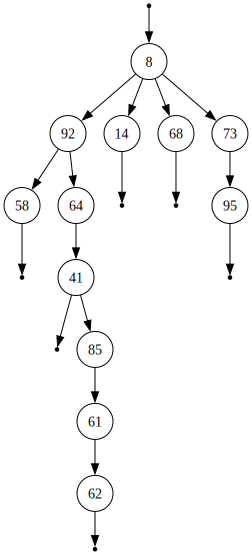

In [26]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(np.abs(P.expr.with_flow.value)>0.5))
sol.plot(orphan_edges=True)

In [27]:
for o in P.objectives:
    print(o.value)

24.49311858165573
139.73652992602086
17.999999999999993
